To identify the spatial domains, eSpatial performed spatial clustering by STAGATE, which was originally designed to identify spatial domains from spatially resolved transcriptomics data. STAGATE utilized a graph attention auto-encoder to acquire low-dimensional latent embeddings with both spatial information and gene expressions. To adapt the application of STAGATE in spatial-ATAC-RNA co-profiling or spatial-ATAC profiling, eSpatial provided three types of spatial clustering methods

# Prepare for input

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import anndata as ad
import STAGATE as STAGATE
import tensorflow as tf
import scanpy as sc

# RNA

Only use spatial-RNA profiling to identify spatial domains

In [2]:
adata = sc.read_h5ad("../outs/E11_PCA.h5ad")
coor_df = adata.obs.loc[:,['cod_1', 'cod_2']]
adata.obsm["spatial"] = coor_df.to_numpy()
adata

AnnData object with n_obs × n_vars = 2099 × 19170
    obs: 'nCount_peaks', 'nFeature_peaks', 'seurat_clusters_rna', 'seurat_clusters_atac', 'seurat_clusters_joint', 'cod_1', 'cod_2'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'spatial'

In [3]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

------Calculating spatial graph...
The graph contains 15444 edges, 2099 cells.
7.3578 neighbors per cell on average.


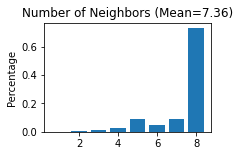

In [4]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=1.5)
STAGATE.Stats_Spatial_Net(adata)

In [5]:
adata = STAGATE.train_STAGATE(adata,
                              alpha=0.8, 
                              pre_labels='seurat_clusters_rna',
                              n_epochs=1000, 
                              save_attention=False)

Size of Input:  (2099, 3000)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2024-04-15 10:01:40.836638: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-04-15 10:01:40.997709: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2024-04-15 10:01:41.019257: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562d8d518f20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-04-15 10:01:41.019319: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-04-15 10:01:41.031670: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-15 10:01:41.032093: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-15 10:01:41.032191: I tensor

------Pruning the graph...
15444 edges before pruning.
10530 edges after pruning.


100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s]


(-2.45, 51.45, -2.45, 51.45)

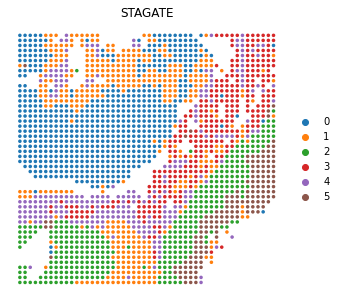

In [6]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=0.7)
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=50, show=False, title='STAGATE')
plt.axis('off')

In [7]:
# adata.obs.to_csv('../outs/E11_rna_meta_pl_a0.8r0.7.csv')

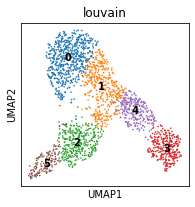

In [8]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color="louvain", legend_loc='on data', s=10)

In [9]:
# pd.DataFrame(adata.obsm['X_umap']).to_csv("../outs/E11_rna_umap_pl_a0.8r0.7.csv")

# ATAC

Only use spatial-ATAC to identify spatial domains

In [10]:
adata = sc.read_h5ad("../outs/E11_LSI_-1.h5ad")
coor_df = adata.obs.loc[:,['cod_1', 'cod_2']]
adata.obsm["spatial"] = coor_df.to_numpy()
adata

AnnData object with n_obs × n_vars = 2099 × 49
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_peaks', 'nFeature_peaks', 'seurat_clusters_rna', 'seurat_clusters_atac', 'seurat_clusters_joint', 'cod_1', 'cod_2'
    var: 'features'
    obsm: 'spatial'

------Calculating spatial graph...
The graph contains 15444 edges, 2099 cells.
7.3578 neighbors per cell on average.


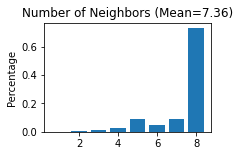

In [11]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=1.5)
STAGATE.Stats_Spatial_Net(adata)

In [12]:
adata = STAGATE.train_STAGATE(adata,
                              alpha=0.8, 
                              pre_labels='seurat_clusters_atac',
                              n_epochs=1000, 
                              save_attention=False)

Size of Input:  (2099, 49)
------Pruning the graph...
15444 edges before pruning.
10850 edges after pruning.


100%|██████████| 1000/1000 [02:03<00:00,  8.13it/s]


(-2.45, 51.45, -2.45, 51.45)

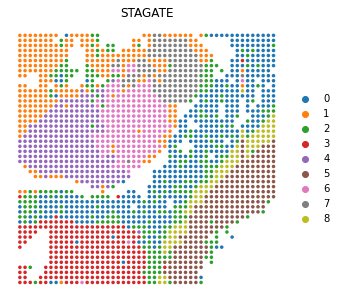

In [13]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=0.7)
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=50, show=False, title='STAGATE')
plt.axis('off')

In [14]:
# adata.obs.to_csv('../outs/E11_LSI_meta_pl_a0.8r0.7.csv')

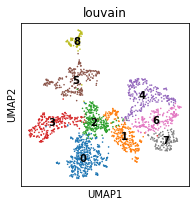

In [15]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color="louvain", legend_loc='on data', s=10)

In [16]:
# pd.DataFrame(adata.obsm['X_umap']).to_csv("../outs/E11_LSI_umap_pl_a0.8r0.7.csv")

# Joint

Use spatial-ATAC-RNA co-profiling to identify spatial domains

In [17]:
adata = sc.read_h5ad("../outs/E11_PCA_LSI.h5ad")
coor_df = adata.obs.loc[:,['cod_1', 'cod_2']]
adata.obsm["spatial"] = coor_df.to_numpy()
adata

AnnData object with n_obs × n_vars = 2099 × 99
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_peaks', 'nFeature_peaks', 'seurat_clusters_rna', 'seurat_clusters_atac', 'seurat_clusters_joint', 'cod_1', 'cod_2'
    var: 'features'
    obsm: 'spatial'

In [18]:
adata.obs['seurat_clusters_rna'].unique()

array([1, 2, 5, 4, 0, 3], dtype=int32)

------Calculating spatial graph...
The graph contains 15444 edges, 2099 cells.
7.3578 neighbors per cell on average.


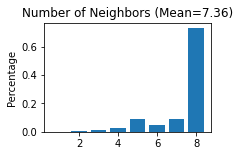

In [19]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=1.5)
STAGATE.Stats_Spatial_Net(adata)

In [20]:
adata = STAGATE.train_STAGATE(adata,
                              alpha=0.8, 
                              pre_labels = 'seurat_clusters_joint',
                              n_epochs=1000, 
                              save_attention=True)

Size of Input:  (2099, 99)
------Pruning the graph...
15444 edges before pruning.
12022 edges after pruning.


100%|██████████| 1000/1000 [01:42<00:00,  9.73it/s]


(-2.45, 51.45, -2.45, 51.45)

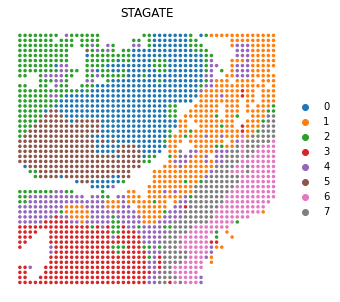

In [21]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=0.7)
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=50, show=False, title='STAGATE')
plt.axis('off')

In [22]:
# adata.obs.to_csv('../outs/E11_PCA_LSI_meta_pl_a0.8r0.7.csv') # save meta data

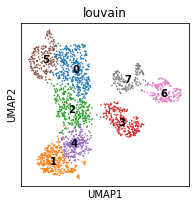

In [23]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color="louvain", legend_loc='on data', s=10)

In [24]:
# pd.DataFrame(adata.obsm['X_umap']).to_csv("../outs/E11_PCA_LSI_umap_pl_a0.8r0.7.csv") # save umap coordinates